# Table of Contents
>## 1. Multi-class Softmax Classification
* 1.1. Algorithm
* 1.2. Visualisation of the Decision Boundaries
* 1.3. MLE
* 1.4. Gradient Ascent
* 1.5. Summary
* 1.6. Questions

>## 2. kNN Classification
* 2.1. Algorithm
* 2.2. Distance Metrics
* 2.3. Example ($k=1$)
* 2.4. Example ($k>1$)
* 2.5. Pros & Cons

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [19]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

# 1. Multi-class Softmax Classification
* Binary classification $\rightarrow$ Generalise for $K>2$
* Input: $\mathbf{x}_n$, Output: $y_n=k$

## 1.1. Algorithm
* **Step 1.** Compute $k$ activations using a weight vector for each class $\{\mathbf{w}_k\}_{k=1}^K$

>$$a_{n,k} = \mathbf{w}_k^\top \mathbf{x}_n$$

* **Step 2.** Pass the activations into a **softmax function** which returns the prob. that $\mathbf{x}_n$ belongs to each of the $K$ classes

>$$
p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\exp(a_{n,k})}{\sum_{k'=1}^K \text{exp}(a_{n,k'})} = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)}{\sum_{k'=1}^K \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)},
$$

>* **NOTE**: Softmax fn. is normalised by construction

>$$\sum_{k=1}^K p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\sum_{k=1}^K \exp(a_{n,k})}{\sum_{k'=1}^K \text{exp}(a_{n,k'})} = 1$$

>* **NOTE**: Softmax fn. parameterises a categorical dist.
>* **NOTE**: Logistic fn. parameterises a Bernoulli dist.

## 1.2. Visualisation of the Decision Boundaries
* $K=3$ classes & $D=2$ dimensional inputs
* **Each column**: different softmax model, each with its own weights, $W^{(m)} = [\mathbf{w}_1^{(m)},\mathbf{w}_2^{(m)},\mathbf{w}^{(m)}_3]$
* **Each row**: how the prob. of each class varies across the input space
* **The probability contours are not linear $\rightarrow$ But the decision boundaries are linear**

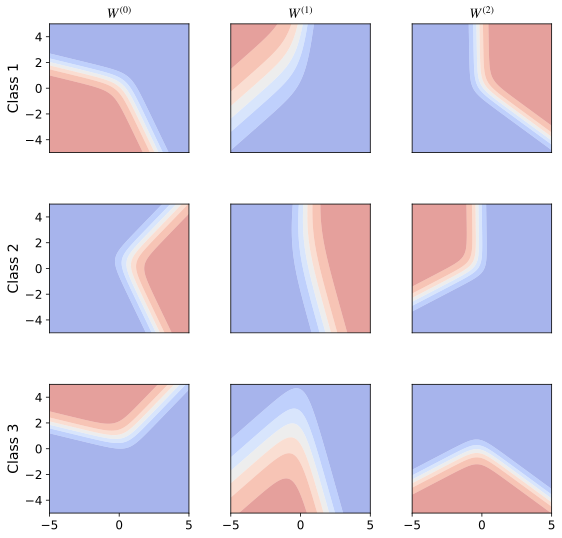

In [11]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x), axis = 1)).T # define softmax function

fig = plt.figure(figsize=(9, 9))

no_increments = 100

x1 = np.linspace(-5,5,no_increments)
x2 = np.linspace(-5,5,no_increments)

for w in range(0,3):
    
    W = np.random.randn(3,3)
    
    grid = np.stack(np.meshgrid(x1,x2), axis = -1)

    grid = grid.reshape((-1, 2))

    grid = np.append(np.ones(shape = (grid.shape[0], 1)), grid, axis = 1)
    
    probs = softmax(grid.dot(W)).reshape((no_increments, no_increments, 3))
    
    for class_ in range(1,4):
        
        # adding a subplot in appropriate location
        ax = fig.add_subplot(3, 3, (class_-1) * 3 + (w+1))
        
        ax.contourf(x1,x2,probs[:,:,class_-1],cmap=matplotlib.cm.coolwarm,alpha=0.5)
        
        if w == 0:
            
            beautify_plot({"y":"Class " + str(class_)})
            
        else:
            
            plt.yticks([])
            
        if class_ == 1:
            
            beautify_plot({"title":r"$W^{(" + str(w) + ")}$"})
            
        if class_ != 3:
        
            plt.xticks([])

plt.subplots_adjust(hspace = 0.4,wspace = 0.3)
plt.show()
        
toggle_code()

## 1.3. MLE
* **Notation**:

>* One-Hot Encoding:
>* Encode the output $y_n=k$ into a vector of length $K$ comprising $K-1$ zeros and a one in the $k^\text{th}$ element
>* Stack OHE into an $N \times K$ matrix with elements $y_{n,k}$

* **Likelihood**:

>\begin{align}
p(\{y_{n}\}_{n=1}^N|\{\mathbf{x}_n\}_{n=1}^N, \{\mathbf{w}_k\}_{k=1}^K) &= \prod_{n = 1}^N \prod_{k = 1}^K s_{n,k}^{y_{n,k}}
\end{align}
>
>* Where:
>
>$$s_{n,k} = p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)}{\sum_{k'} \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)}$$
>

* **LL**:

>\begin{align}
\mathcal{L}(\{\mathbf{w}\}_{k=1}^K) &= \sum_{n = 1}^N \sum_{k = 1}^K y_{n,k} \log s_{n,k}
\end{align}

* **Derivative of LL**:

>\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} = \sum^N_{n = 1} (y_{n,j} - s_{n,j}) \mathbf{x}_n
\end{align}


<details>
<summary>Derivation of the gradient of the softmax log-likelihood</summary>
<div>
    Starting from the expression

\begin{align}
\mathcal{L}(\{\mathbf{w}\}_{k=1}^K) &= \sum_{n = 1}^N \sum_{k = 1}^K y_{n,k} \text{log}~s_{n,k},
\end{align}

and taking the derivative w.r.t. $\mathbf{w}_j$ we see:


\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} \frac{1}{s_{n,k}} \frac{\partial s_{n,k}}{\partial \mathbf{w}_j} = \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} \frac{1}{s_{n,k}} \frac{\partial s_{n,k}}{\partial a_{n,j}} \frac{\partial a_{n,j}}{\mathbf{w}_j}\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k} (\delta_{k,j} - s_{n,j}) \mathbf{x}_n\\
~\\
\end{align}

where $\delta_{k,j}$ is a [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) and we have used the identity

\begin{align}
\frac{\partial s_{n,k}}{ \partial a_{n,j}} = s_{n,k}(\delta_{k,j} - s_{n,j}).
\end{align}

Then considering that for each $n$, $y_{n,k}$ is $1$ for a single value of $k$ and $0$ for all other values of $k$:

\begin{align}
\frac{\partial \mathcal{L}(\{\mathbf{w}\}_{k=1}^K)}{\partial \mathbf{w}_j} &= \sum_{n = 1}^N\sum_{k = 1}^K y_{n,k}(\delta_{k,j} - s_{nj})\mathbf{x}_n\\
~\\
&= \sum_{n = 1}^N\sum_{k = 1}^K (y_{n,j} - s_{n,j})\mathbf{x}_n\\
\end{align}

arriving at the final result.
</div>
</details>

* **Visualisation of the Likelihood**:

>* All 3 classess included / Only 2 input dimensions retained (sepal length & width)

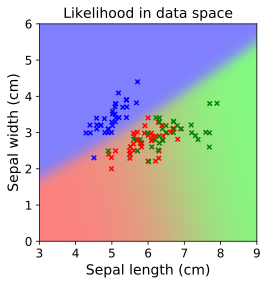

In [13]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

y_ = np.zeros(shape = (y.shape[0], 3))
y_[np.arange(y.shape[0]), y] = 1

no_train = (x.shape[0] * 3) // 4
x_train, x_test, y_train, y_test = x[:no_train, :2], x[no_train:, :2], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)

min_x, max_x, min_y, max_y, res = 3, 9, 0, 6, 1000
grid = np.stack(np.meshgrid(np.linspace(min_x, max_x, res), np.linspace(min_y, max_y, res)), axis = -1)
grid = grid.reshape((-1, 2))
grid = np.append(np.ones(shape = (grid.shape[0], 1)), grid, axis = 1)

probs = softmax(grid.dot(w_history[-1])).reshape((res, res, 3))
rgb_colors = np.roll(probs, -1, axis  = -1)
plt.imshow(rgb_colors, extent = [min_x, max_x, min_y, max_y], alpha = 0.5, origin='lower')
plt.scatter(x_train[:, 0], x_train[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y[:no_train]])
beautify_plot({"title":r"Likelihood in data space", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

toggle_code()

## 1.4. Gradient Ascent
* Apply the gradient ascent algorithm to the full Iris dataset, with all input dimensions retained

In [12]:
def softmax(x):
    return (np.exp(x).T/np.sum(np.exp(x), axis = 1)).T # define softmax function for convenience

def softmax_gradient_ascent(x, y, init_weights, no_steps, stepsize):
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as before
    
    w = init_weights.copy() # copy weights as before
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods as before

    for n in range(no_steps): # in this part we optimise log-lik w.r.t. ws
        
        log_liks.append(np.sum(y*np.log(softmax(x.dot(w))))) # record current log-lik as before
        
        w_history.append(w.copy()) # record current weights as before
    
        soft_ = softmax(x.dot(w)) # using our neat convenience function
        
        dL_dw = (x.T).dot(y - soft_)/x.shape[0]
        
        w += stepsize*dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks)

toggle_code(title = "gradient ascent algorithm", on_load_hide = False)

* **Change in LL**:

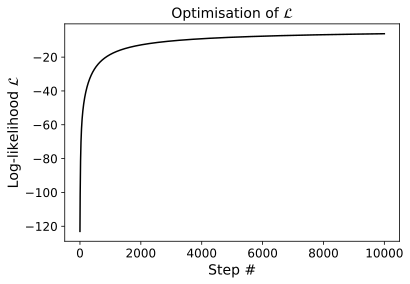

In [14]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

y_ = np.zeros(shape = (y.shape[0], 3))
y_[np.arange(y.shape[0]), y] = 1

no_train = (x.shape[0] * 3) // 4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y_[:no_train], y_[no_train:]

init_weights = np.zeros(shape = (x_train.shape[1] + 1, 3))

w_history, log_liks = softmax_gradient_ascent(x_train, y_train, init_weights, 10 ** 4, 0.05)
beautify_plot({"title":r"Optimisation of $\mathcal{L}$", "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})
plt.plot(log_liks, color = 'black')
plt.show()

toggle_code()

* **Accuracy**:

In [15]:
def softmax_test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = softmax(x_.dot(w))
    return (np.argmax(y_, axis = 1) == np.argmax(y_test, axis = 1)).mean()

print('Classification accuracy for full iris dataset = {0:.1f}%'.format(softmax_test_accuracy(x_test, y_test, w_history[-1])*100))

toggle_code()

Classification accuracy for full iris dataset = 94.7%


## 1.5. Summary

**Step 1.** Compute $K$ activations, one for each class, each of which are linear projections of the input $a_{n,k} = \mathbf{w}_k^\top \mathbf{x}_n$

**Step 2.** Pass the $K$ activations into the softmax function to get a vector of $K$ elements which are the class membership probabilities $p(y_{n} = k |\mathbf{x}_n, \{\mathbf{w}_k\}_{k=1}^K) = \text{exp}(\mathbf{w}_k^\top \mathbf{x}_n)\big/\sum_{k'} \exp(\mathbf{w}_{k'}^\top \mathbf{x}_n)$

**Step 3.** Use OHE to write LL and its derivative more compactly

**Step 4.** Numerical optimisation of LL using **Gradient Ascent**

## 1.6. Questions

* **Q1. Why the name 'softmax' and relating softmax classification to logistic classification**

Consider the softmax classification function:

$$
p(y_{k} = k |\mathbf{x}, \{\mathbf{w}_k\}_{k=1}^K)  = \frac{\text{exp}(\mathbf{w}_k^\top \mathbf{x})}{\sum_{k'=1}^K \exp(\mathbf{w}_{k'}^\top \mathbf{x})},
$$

What happens to the softmax function as the magnitude of the weights tends to infinity $|\mathbf{w}_k| \rightarrow \infty$?

Consider K=2 classes, compare and contrast the softmax classification model to binary logistic classification. Is the softmax function **[identifiable](https://en.wikipedia.org/wiki/Identifiability)**?

<details>
<summary>Answer</summary>
<div>
   
   <div class="row">
  <div class="column">
    <img src="softmax-solution-1.png" alt="Snow" style="width:100%; float: center; padding: 0px">
    <img src="softmax-solution-2.png" alt="Snow" style="width:100%; float: center; padding: 0px">
  </div>
    </div>
    Notice that although the softmax and logistic functions are identical for $K=2$ classes, the parameterisation is different. The softmax version is over-parameterised having two sets of parameters whose difference affects the input-output function. For this reason the parameters of the softmax are not identifiable: adding the same vector to each weight $\mathbf{w}_k \leftarrow \mathbf{w}_k + \mathbf{b}$ causes no change in the input-output function.

</div>
</details>

* **Q2. Making multi-class classifiers from binary classifiers**

Alice has a multi-class classification problem, but only has access to code for training and making predictions from a binary classifier. Devise heuristic approaches for using a set of binary classiers to solve a multi-class problem. Compare and contrast these approaches to softmax classification. 

<details>
<summary>Answer</summary>
<div>
There are a variety of ways of transforming a multi-class classification problem to a binary one (see [here](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest))    <br><br>
    
A simple technique is to train K all-versus-one classifiers each of which classifies an input into either belonging to class k or one of the other K-1 classes. A test point can be run through each of these classifiers and the largest output picked. <br><br>

Alternatively, a set of pairwise binary classifiers could be built, potentially for all K(K-1)/2 pairs of classification problems and the winning class selected by majority vote.<br><br>

Another approach is to build a tree of classifiers. E.g. if there are four classes, the root classifier might first split the input into classes (1 & 2) vs (3 & 4) with two leaf classifiers making the final classification (1 vs 2) and (3 vs 4). This approach would involve building the tree (i.e. figuring out which classes to group together at the non-leaf nodes). **Decision trees** and **random forests** take approaches of this sort. 
</div>
</details>

# 2. kNN Classification
* kNN: k-nearest neighbours

## 2.1. Algorithm
* **Step 1**. Choose the $k$ nearest neighbours based on appropriate distance metric
* **Step 2**. Choose the most commonly occuring class
* **Step 3**. 2+ classess with the most occurences $\rightarrow$ choose randomly among them
* **Step 4**. Use this as the estimate for the class of $\mathbf{x}$
* **NOTE: Training is not needed $\rightarrow$ Simply store the training set for comparison with future datapoints**

## 2.2. Distance Metrics
* Choosing the appropriate distance metric is important when:
  * The data is high-dimensional
  * The inputs have different units
  
>\begin{align}
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \sum_{d} \big|x_{1,d} - x_{2,d}\big|,~\text{sum of absolute values ($L1$ distance)}\\
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \bigg[\sum_{d} \big|x_{1,d} - x_{2,d}\big|^2\bigg]^{1/2},~\text{Euclidian distance ($L2$ distance)}\\
~\\
d(\mathbf{x}_1, \mathbf{x}_2) &= \bigg[\sum_{d} \big|x_{1,d} - x_{2,d}\big|^p\bigg]^{1/p},~\text{$p^{th}$ norm  ($Lp$ distance)}\\
\end{align}

## 2.3. Example ($k=1$)

* **Step 1.** Determine **decision boundaries** (or **decision surfaces**)

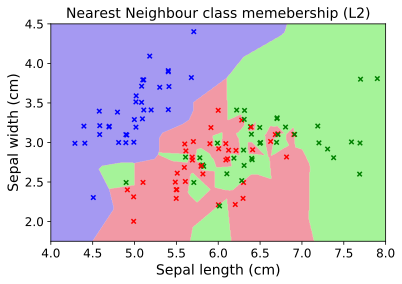

<IPython.core.display.HTML object>

In [4]:
x = np.load('iris_inputs_2d.npy')
y = np.load('iris_labels.npy')

no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

s_len, s_wid = np.linspace(4, 8, 500), np.linspace(1.75, 4.5, 500) # sepal lengths/widths to evaluate class membership

grid = np.stack(np.meshgrid(s_len, s_wid), axis = -1) # stack into (500, 500, 2) array to do arithmetic

cloned_grid = np.stack([grid] * no_train, axis = -2) # copy grid no_train times into a (500, 500, no_train, 2) array


# the whole algorithm is contained in these 3 lines
distances = np.sum((cloned_grid - x_train)**2, axis = -1) # compute L2 to get a (500, 500, no_train) array

idx = np.argmin(distances, axis = -1).reshape((-1,)) # find closest point to each training point, then flatten

classes = y_train[idx].reshape(500, 500) # classify each grid point according to the closest training point


plt.contourf(s_len, s_wid, classes, cmap = 'brg', alpha = 0.4) # plot membership areas
plt.scatter(x_train[:, 0], x_train[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y_train]) # plot data
beautify_plot({"title":"Nearest Neighbour class memebership (L2)", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

HTML(toggle_code())

* **Step 2.** Apply this on test set

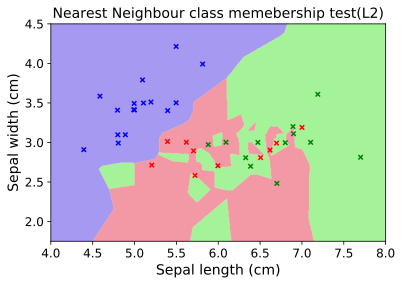

<IPython.core.display.HTML object>

In [6]:
# plot class the memebrships and the test points
plt.contourf(s_len, s_wid, classes, cmap = 'brg', alpha = 0.4)
plt.scatter(x_test[:, 0], x_test[:, 1], marker = 'x', s = 20, color = np.array(['b', 'r', 'g'])[y_test])
beautify_plot({"title":"Nearest Neighbour class memebership test(L2)", "x":"Sepal length (cm)", "y":"Sepal width (cm)"})
plt.show()

HTML(toggle_code())

In [22]:
x_test_clone = np.stack([x_test] * no_train, axis = -2) # clone test points into (no_test, no_train, 2) array

distances_test = np.sum((x_test_clone - x_train) ** 2, axis = -1) # compute L2 distances as before

idx = np.argmin(distances_test, axis = -1) # find closest point to each training point ()

classes_test = y_train[idx] # classify training points

accuracy = (classes_test == y_test).mean() * 100 # calculate classification accuracy
print("Classification accuracy on test set of {} points = {}%".format(y_test.shape[0], accuracy.round(2)))

HTML(toggle_code())

Classification accuracy on test set of 38 points = 98.25%


<IPython.core.display.HTML object>

## 2.4 Example ($k>1$)

* **Step 1.** Program kNN algorithm

In [23]:
def kNN(X_train, Y_train, X_test, k, p = 2):
    
    X_test_clone = np.stack([X_test] * X_train.shape[0], axis = -2) # clone test points for comparisons as before
    
    distances = np.sum(np.abs(X_test_clone - X_train) ** p, axis = -1) # compute Lp distances
    
    idx = np.argsort(distances, axis = -1)[:, :k] # find k smallest distances
    
    classes = y_train[idx] # classes corresponding to the k smallest distances
    
    predictions = []
    
    for class_ in classes:
        
        uniques, counts = np.unique(class_, return_counts = True) # getting the set of classes, and counting the occurences
        
        if (counts == counts.max()).sum() == 1: # checking if there is a unique class with the most occurences in the kNN
            
            predictions.append(uniques[np.argmax(counts)]) # adding the class with the most occurences to predictions
            
        else:
            
            # if multiple classes have the maximum occurences in the kNN, choose randomly among them
            
            predictions.append(np.random.choice(uniques[np.where(counts == counts.max())[0]])) 
            
            
    return np.array(predictions) # return the predictions

HTML(toggle_code(title='kNN algorithm'))

<IPython.core.display.HTML object>

* **Step 2.** Repeat the process for different values of $k$

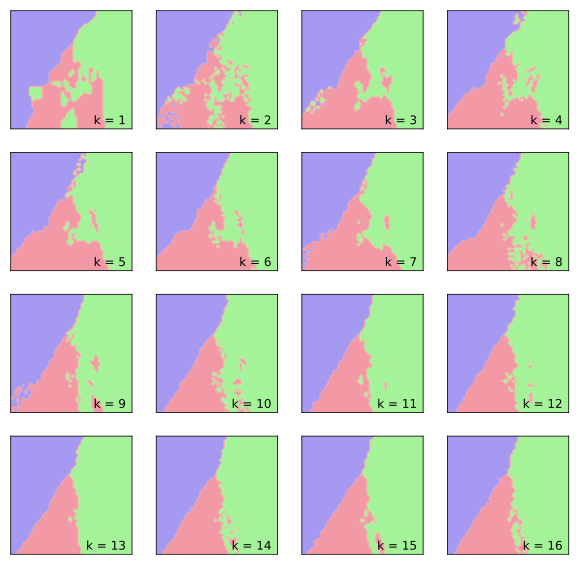

<IPython.core.display.HTML object>

In [8]:
no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

s_len, s_wid = np.linspace(4, 8, 50), np.linspace(1.75, 4.5, 50) # sepal lengths/widths to evaluate class membership

grid = np.stack(np.meshgrid(s_len, s_wid), axis = -1) # stack into (500, 500, 2) array to do arithmetic

flat_grid = grid.reshape((-1, x_train.shape[1])) # 

plt.figure(figsize  = (10, 10))

for k in range(1,17):

    classes = kNN(x_train, y_train, flat_grid, k, p = 2) # call the kNN function to get the classes of the points

    plt.subplot(4, 4, k)
    plt.contourf(s_len, s_wid, classes.reshape(grid.shape[:-1]), cmap = 'brg', alpha = 0.4) # plot membership areas
    plt.text(7.8, 1.8, s = 'k = ' + str(k), color = 'black', fontsize = 12,
                 horizontalalignment = 'right', verticalalignment = 'bottom')
    remove_axes()

plt.show()

HTML(toggle_code())

* **Step 3.** Apply **n-fold CV** to choose the best $k$

  * Plot **mean accuracy** ± **stdev**
  * Same approach can be used to choose $p$

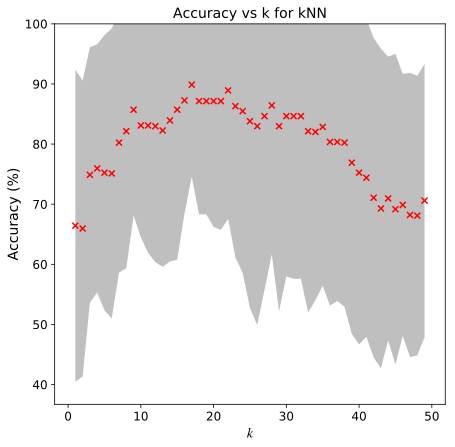

<IPython.core.display.HTML object>

In [9]:
no_folds = 15

k_max = 50

x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

no_train = (x.shape[0] * 3) // 4 # keep 3/4 points in the training and 1/4 in the test sets

x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:] # select training/test points

plt.figure(figsize  = (7, 7))

means, stdevs = np.zeros((2, k_max - 1))

for k in range(1, k_max):
    
    accuracies = np.zeros((no_folds,))
    
    for v in range(no_folds):
        
        x_folds, y_folds = np.array_split(x_train, no_folds), np.array_split(y_train, no_folds)
        
        x_validation, y_validation = x_folds.pop(v), y_folds.pop(v)
        
        x_train_rem, y_train_rem = np.concatenate(x_folds), np.concatenate(y_folds)

        classes = kNN(x_train_rem, y_train_rem, x_validation, k, p = 2) # call the kNN function to get the classes of the points
        
        accuracies[v] = (classes == y_validation).mean() * 100
    
    means[k-1] = accuracies.mean()
    
    stdevs[k-1] = accuracies.var() ** 0.5

plt.fill_between(np.arange(1,50), means + stdevs, means - stdevs, facecolor = 'grey', alpha = 0.5)
plt.scatter(np.arange(1,50), means, marker = 'x', color = 'red')
beautify_plot({"title":"Accuracy vs k for kNN", "x":"$k$", "y":"Accuracy (%)"})
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,100))
plt.show()

HTML(toggle_code())

## 2.5. Pros & Cons
* **Pros**:
  * Can be effective for low-dim data
  * Does not require any time to train
* **Cons**:
  * Computational expensive to store and perform computation on the entire training set
  * We often prefer models that are expensive to train but cheap to use
  * Only accounts for hard (discrete) decision boundaries (no measure of uncertainty)